![MLA Logo](https://drive.corp.amazon.com/view/mrruckma@/MLA_headerv2.png?download=true)

In [1]:
!pip install --upgrade pip
!pip install -U scikit-image

    100% |████████████████████████████████| 1.5MB 18.5MB/s ta 0:00:01
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
     |████████████████████████████████| 12.4 MB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 57.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 62.5 MB/s eta 0:00:01
     |████████████████████████████████| 18.1 MB 45.0 MB/s eta 0:00:01
  Attempting uninstall: PyWavelets
    Found existing installation: PyWavelets 0.5.2
    Uninstalling PyWavelets-0.5.2:
      Successfully uninstalled PyWavelets-0.5.2
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.13.1
    Uninstalling scikit-image-0.13.1:
      Successfully uninstalled scikit-image-0.13.1


### 1. Download the Dataset

Our labels correspondend to the following:

    Class 0: Inconclusive
    Class 1: Two wheels
    Class 2: Four wheels
    Class 3: Not luggage
    Class 4: Zero wheels



We are reading it into a Data Frame. 

In [74]:
#Let's read in our training data. ASINs correspond to those in Leaderboard's ID.
import pandas as pd
import numpy as np
from sklearn.utils import resample

df = pd.read_pickle("/tmp/training_data.pkl")

# slight cheat, add in the other test data as class "other", we'll need 657 -36 samples
if 1 :
    dsup = pd.read_pickle("/tmp/example_dataset.pkl")
    df2 = pd.DataFrame({'ID': dsup['ID'],
                        'data': dsup['data'],
                        'label': 3})
    df2 = resample(df2, 
                   replace=True, # sample with replacement
                   n_samples=621, # upsample to match class 3
                   random_state=123 # reproducible result
                   )
    print(len(df))
    print(len(df2))
    print(df.head())
    df = df.append(df2,ignore_index=True)#
    print(len(df))
    print(df.head())
    # shuffle the new values in and clear mem
    df = df.sample(frac=1)
    del dsup
    del df2


1796
621
     ID                                               data  label
0  1588  [[[255, 255, 255], [255, 255, 255], [255, 255,...      4
1  2011  [[[255, 255, 255], [255, 255, 255], [255, 255,...      1
2  1321  [[[255, 255, 255], [255, 255, 255], [255, 255,...      4
3   669  [[[255, 255, 255], [255, 255, 255], [255, 255,...      3
4  1674  [[[255, 255, 255], [255, 255, 255], [255, 255,...      1
2417
     ID                                               data  label
0  1588  [[[255, 255, 255], [255, 255, 255], [255, 255,...      4
1  2011  [[[255, 255, 255], [255, 255, 255], [255, 255,...      1
2  1321  [[[255, 255, 255], [255, 255, 255], [255, 255,...      4
3   669  [[[255, 255, 255], [255, 255, 255], [255, 255,...      3
4  1674  [[[255, 255, 255], [255, 255, 255], [255, 255,...      1


### Let's plot some images below.

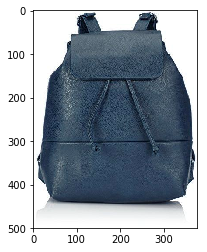

In [4]:
#Let's see what kind of data we're working with
import matplotlib.pyplot as plt

plt.imshow(df['data'][91])

In [3]:
# Let's take a look at this data in more detail and then start working. Remember 'label' is our target variable/column
df.loc[91]


ID                                                      98
data     [[[255, 255, 255], [255, 255, 255], [255, 255,...
label                                                    4
Name: 91, dtype: object

### Image Functions

In [75]:
import random
import skimage as sk
from skimage import transform
from skimage import util
import numpy as np

# Rotate the image with a given angle
def rotate_image(image_array, angle):
    # Rotate the image by the given angle 
    # We usually have white background in images, 
    # we will fill 1s (white) for the areas outside of image boundaries
    return sk.transform.rotate(image_array, angle, cval=1)

# Add random noise to image
def random_noise(image_array):
    # add random noise to the image
    return sk.util.random_noise(image_array)
    
# Flip the image at a given axis
def image_flip(image_array, axis):
    # axis=0 => vertical flip
    # axis=1 => horizontal flip
    return np.flip(image_array, axis=axis)

def getImage(im, modfn):
        # If we want to mod, then modify according to modfnnum. There's probably Pyton way to switch case but????
        if modfn == 1 :
            im = image_flip(im, 1)
        if modfn == 2 :
            im = random_noise(im)
        if modfn == 3 :
            im = image_flip(im, 1)
            im = random_noise(im)
        if modfn == 4 :
            im = rotate_image(im, 20)
        if modfn == 5 :
            im = rotate_image(im, -20)
        
        # We need a fixed size input, our images have different sizes, let's pick 224x224.
        # Resize image below
        im = resize(im, output_shape=(224, 224))
        
        # Gluon/mxnet expects images in this format (channel, row, column)
        # This is the opposite of (row, column, channel), let's fix it
        im = np.moveaxis(im, -1, 0)
        
        # return an image ready for use
        return im
    
def getImages(images, modfn):
    # Create the image holder array
    image_arr = np.zeros((images.shape[0], 3, 224, 224), dtype="float32")
    
    # Iterate through the image data
    for i, im in enumerate(images):        
        # Assign the modified image in the image array
        image_arr[i] = getImage(im, modfn)

    return image_arr

# This will create additional training data from a small set of indexes 
# we rotate through flip, noise, flip+noise, original until we have the number we need
def paddedTrainingData (df, indexes, count) :
    image_arr = np.zeros((count, 3, 224, 224), dtype="float32")
    label_arr = np.zeros((count), dtype="int64")
    modfn = 0
    for i in range(count) :
        item_index = i % len(indexes)
        # when item index cycles, inc the modifier function will run first time so we start at 1
        if item_index == 0 :
            modfn = (modfn + 1) % 4 #only want fns 0-3
        image_arr[i] = getImage(df.loc[indexes[item_index]]['data'], modfn)
        label_arr[i] = df.loc[indexes[item_index]]['label']
    return {'images':image_arr, 'labels':label_arr}

### 2. Split the dataset and Process Images
#### * We split the original dataset into Training (80%), Validation (10%) and Test (10%) subsets. 
#### * We will process images by resizing to 224x224 and converting (row, column, channel) to (channel, row, column)

In [76]:
import numpy as np
from skimage.transform import resize
from skimage.transform import rotate
from mxnet import gluon
from sklearn.utils import shuffle

# Let's split to data into training (90%), validation (10%) subsets (test is seperate file).
train_indices = np.arange(0, int(0.9*len(df)))
val_indices = np.arange(int(0.9*len(df)), len(df))

# get indexes used to balance test data (not very pythony)
bal_indices_0 = []
bal_indices_1 = []
bal_indices_2 = []
bal_indices_3 = []
bal_indices_4 = []
for i in train_indices:
    if df.loc[train_indices[i]].label == 0 :
        bal_indices_0 = np.append(bal_indices_0, np.full(1, train_indices[i]))
    if df.loc[train_indices[i]].label == 1 :
        bal_indices_1 = np.append(bal_indices_1, np.full(1, train_indices[i]))
    if df.loc[train_indices[i]].label == 2 :
        bal_indices_2 = np.append(bal_indices_2, np.full(1, train_indices[i]))
    if df.loc[train_indices[i]].label == 3 :
        bal_indices_3 = np.append(bal_indices_3, np.full(1, train_indices[i]))
    if df.loc[train_indices[i]].label == 4 :
        bal_indices_4 = np.append(bal_indices_4, np.full(1, train_indices[i]))

train_df = df.iloc[train_indices]
val_df = df.iloc[val_indices]

# first lets get all the training and validation images as is (no augmentation)
train_images, train_labels = getImages(train_df["data"].values, 0), train_df["label"].values
validation_images, validation_labels = getImages(val_df["data"].values, 0), val_df["label"].values

#now simple balancing of #0
print ("padding #0 ", len(bal_indices_1), len(bal_indices_0))
pad_data = paddedTrainingData(df, bal_indices_0, 663 - len(bal_indices_0))
train_images = np.vstack((train_images, pad_data['images']))
train_labels = np.append(train_labels, pad_data['labels'])
#now very simple balancing of #2
print ("padding #2 ", len(bal_indices_1), len(bal_indices_2))
pad_data = paddedTrainingData(df, bal_indices_2, 663 - len(bal_indices_2))
train_images = np.vstack((train_images, pad_data['images']))
train_labels = np.append(train_labels, pad_data['labels'])
#now very simple balancing of #3
#print ("padding #3 ", len(bal_indices_1), len(bal_indices_3))
#pad_data = paddedTrainingData(df, bal_indices_3, 663 - len(bal_indices_3))
#train_images = np.vstack((train_images, pad_data['images']))
#train_labels = np.append(train_labels, pad_data['labels'])
#now very simple balancing of #4
print ("padding #4 ", len(bal_indices_1), len(bal_indices_4))
pad_data = paddedTrainingData(df, bal_indices_4, 663 - len(bal_indices_4))
train_images = np.vstack((train_images, pad_data['images']))
train_labels = np.append(train_labels, pad_data['labels'])

# clean up
del df
del val_df
del pad_data

#Shuffle training data
train_images, train_labels = shuffle(train_images, train_labels)

# Using Gluon Data loaders to load the data in batches
train_dataset = gluon.data.ArrayDataset(train_images, train_labels)
validation_dataset = gluon.data.ArrayDataset(validation_images, validation_labels)

padding #0  731 90
padding #2  731 564
padding #4  731 372


### Look at some of the results

3138
3138
3
731 731


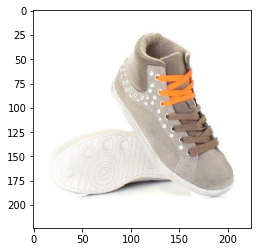

In [77]:

#train_images = np.vstack((train_images, bal_images))
#train_labels = np.append(train_labels,bal_labels)
print(len(train_images))
print(len(train_labels))
print(train_labels[100])
print(len(bal_indices_1), bal_indices_1.size)

#pad_data = paddedTrainingData(df, bal_indices, 200)
#print(len(pad_data['labels']))
#print(len(pad_data['images']))
plt.imshow(np.moveaxis(train_images[100], 0, -1))

### 3. Plot the training class distribution

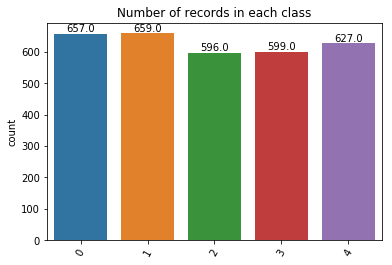

In [78]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure()
ax = sb.countplot(x=train_labels, y = None)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(y, (x.mean(), y), ha='center', va='bottom') 
plt.xticks(rotation=60)
plt.title('Number of records in each class')
plt.show()

### 3. Plot the test class distribution

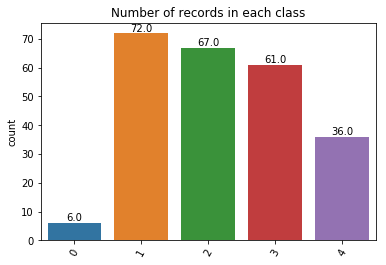

In [79]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure()
ax = sb.countplot(x=validation_labels, y = None)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(y, (x.mean(), y), ha='center', va='bottom') 
plt.xticks(rotation=60)
plt.title('Number of records in each class')
plt.show()

### 4. Confusion Matrix 
#### We have the following function to plot confusion matrix. We will call this function to plot confusion matrix for our validation data after each epoch (one full pass through the training dataset)


In [80]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in ['0', '1', '2', '3', '3']], columns = [i for i in ['0', '1', '2', '3', '4']])
    plt.figure(figsize = (5, 5))
    plt.title('Validation Confusion Matrix')
    sn.heatmap(df_cm, annot=True)
    plt.show()

### 3. Build the Convolutional Neural Network
* We will use two Convolution-Pooling pairs
* Flatten after them
* A fully connected layer
* Dense output layer

In [81]:
from mxnet.gluon.model_zoo import vision
import mxnet as mx

def build_network(num_outputs):
    # Set this to GPU or CPU
    ctx = mx.gpu()
    #ctx = mx.cpu()

    # Get the pre-trained network
    pre_trained_net = vision.alexnet(pretrained=True, ctx=ctx)
    #pre_trained_net = vision.resnet18_v2(pretrained=True, ctx=ctx)
    #pre_trained_net = vision.resnet34_v2(pretrained=True, ctx=ctx)
    #pre_trained_net = vision.vgg11(pretrained=True, ctx=ctx)

    # Get the non-trained network
    net = vision.alexnet(classes=num_outputs, ctx=ctx)
    
    # Initialize weights
    net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
    
    # Copy weights from the trained network
    net.features = pre_trained_net.features

    return net

### 5. Training the network
#### Let's put the training data in the MXnet format and start training. Summarizing our steps:
#### * Select the correct compute type cpu or gpu
#### * Split the dataset into training, validation and test splits
#### * Create Gluon-specific data loaders
#### * Create the network and training algorithm
#### * Loop through dataset. We have only 5 epochs thaks to pre-trained network. We will train with training dataset and validate with the validation dataset.

Parameter alexnet21_conv0_weight (shape=(64, 3, 11, 11), dtype=<class 'numpy.float32'>)
Parameter alexnet21_conv0_bias (shape=(64,), dtype=<class 'numpy.float32'>)
Parameter alexnet21_conv1_weight (shape=(192, 64, 5, 5), dtype=<class 'numpy.float32'>)
Parameter alexnet21_conv1_bias (shape=(192,), dtype=<class 'numpy.float32'>)
Parameter alexnet21_conv2_weight (shape=(384, 192, 3, 3), dtype=<class 'numpy.float32'>)
Parameter alexnet21_conv2_bias (shape=(384,), dtype=<class 'numpy.float32'>)
Parameter alexnet21_conv3_weight (shape=(256, 384, 3, 3), dtype=<class 'numpy.float32'>)
Parameter alexnet21_conv3_bias (shape=(256,), dtype=<class 'numpy.float32'>)
Parameter alexnet21_conv4_weight (shape=(256, 256, 3, 3), dtype=<class 'numpy.float32'>)
Parameter alexnet21_conv4_bias (shape=(256,), dtype=<class 'numpy.float32'>)
Parameter alexnet21_dense0_weight (shape=(4096, 9216), dtype=float32)
Parameter alexnet21_dense0_bias (shape=(4096,), dtype=float32)
Parameter alexnet21_dense1_weight (shape

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


Epoch 0, training loss: 1.69, validation loss: 0.98, training accuracy: 0.38, validation accuracy: 0.64


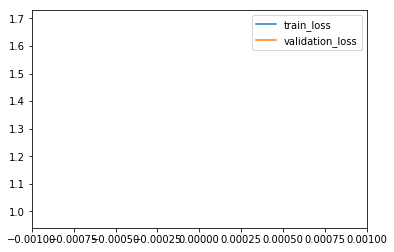

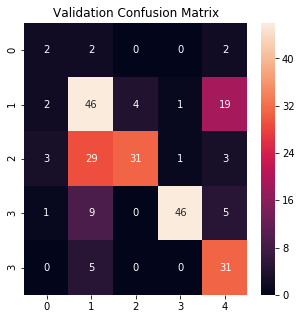

Epoch 1, training loss: 0.88, validation loss: 0.70, training accuracy: 0.66, validation accuracy: 0.74


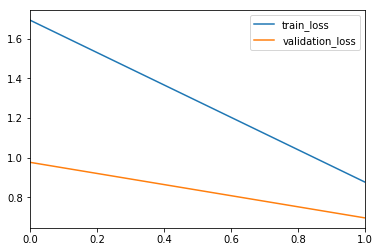

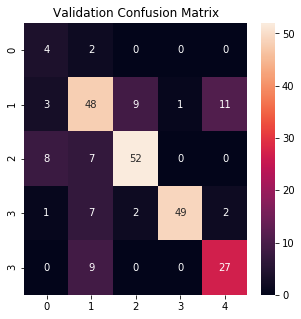

Epoch 2, training loss: 0.67, validation loss: 0.52, training accuracy: 0.74, validation accuracy: 0.79


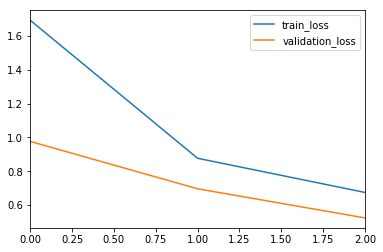

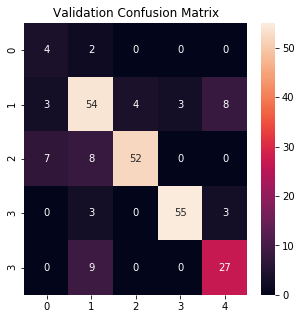

Epoch 3, training loss: 0.56, validation loss: 0.46, training accuracy: 0.79, validation accuracy: 0.83


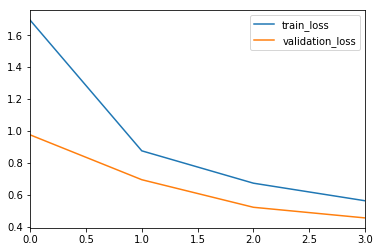

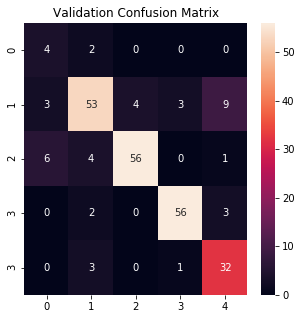

Epoch 4, training loss: 0.49, validation loss: 0.44, training accuracy: 0.82, validation accuracy: 0.85


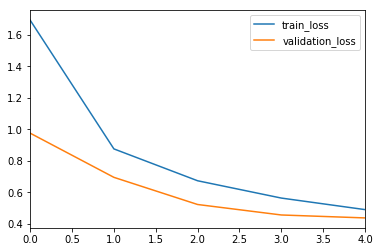

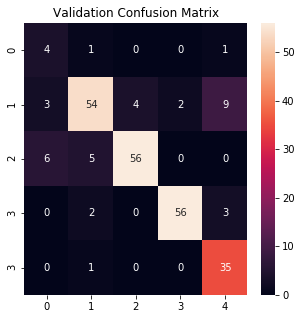

Epoch 5, training loss: 0.44, validation loss: 0.42, training accuracy: 0.84, validation accuracy: 0.85


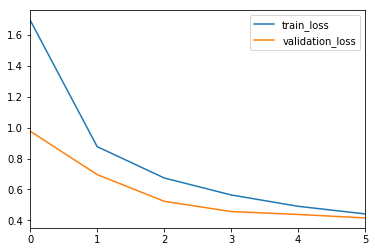

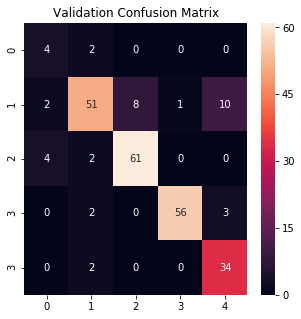

Epoch 6, training loss: 0.39, validation loss: 0.42, training accuracy: 0.86, validation accuracy: 0.83


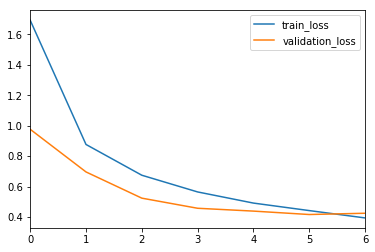

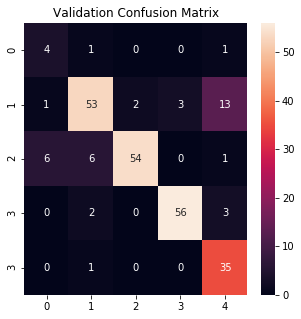

Epoch 7, training loss: 0.36, validation loss: 0.40, training accuracy: 0.87, validation accuracy: 0.85


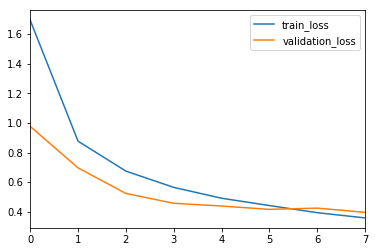

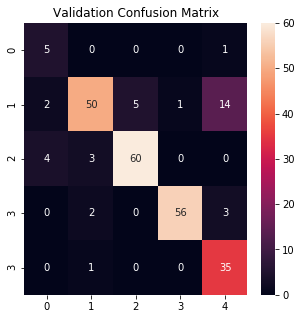

Epoch 8, training loss: 0.34, validation loss: 0.35, training accuracy: 0.87, validation accuracy: 0.86


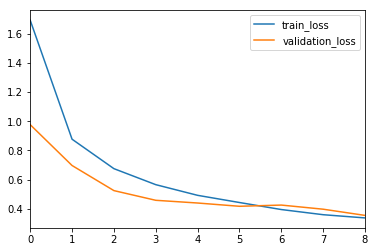

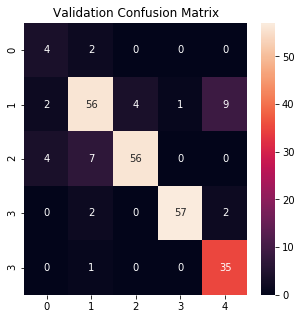

Epoch 9, training loss: 0.31, validation loss: 0.34, training accuracy: 0.89, validation accuracy: 0.88


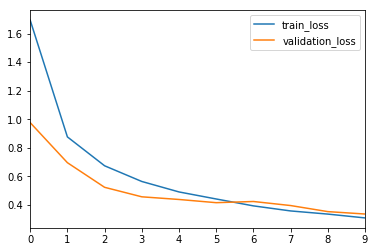

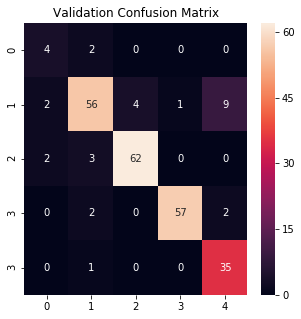

Epoch 10, training loss: 0.27, validation loss: 0.33, training accuracy: 0.91, validation accuracy: 0.87


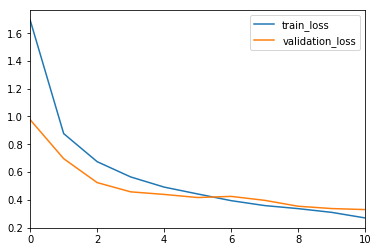

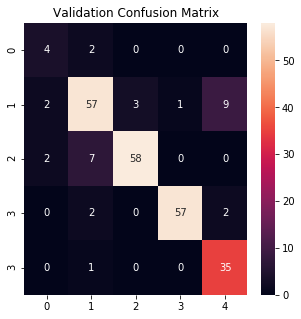

Epoch 11, training loss: 0.27, validation loss: 0.32, training accuracy: 0.90, validation accuracy: 0.87


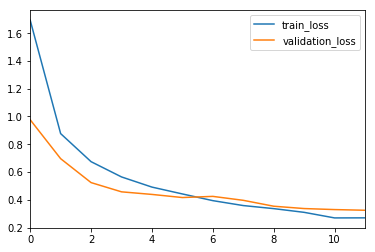

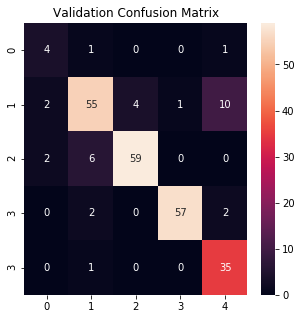

Epoch 12, training loss: 0.23, validation loss: 0.33, training accuracy: 0.91, validation accuracy: 0.89


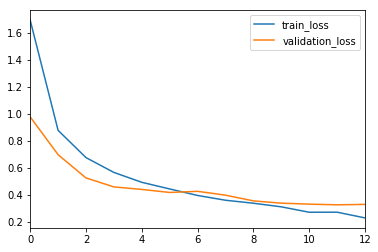

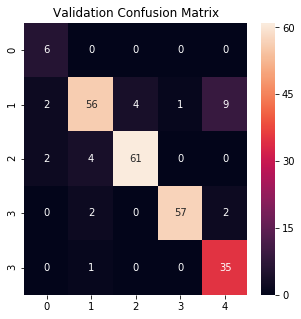

Epoch 13, training loss: 0.23, validation loss: 0.34, training accuracy: 0.92, validation accuracy: 0.87


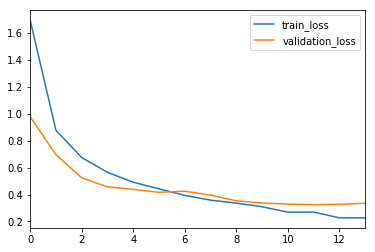

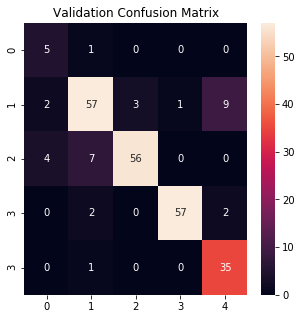

Epoch 14, training loss: 0.21, validation loss: 0.33, training accuracy: 0.93, validation accuracy: 0.86


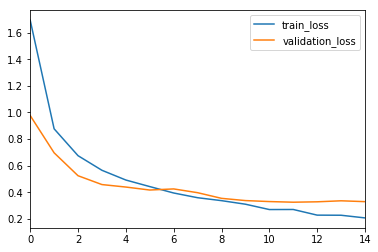

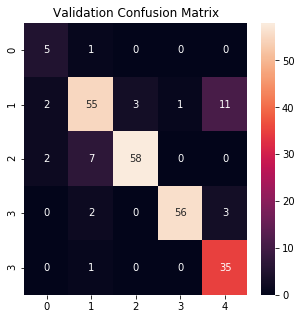

Epoch 15, training loss: 0.19, validation loss: 0.39, training accuracy: 0.93, validation accuracy: 0.85


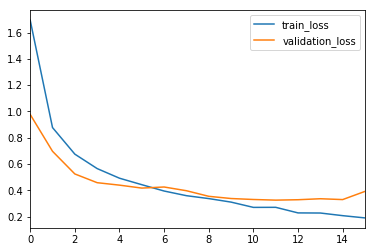

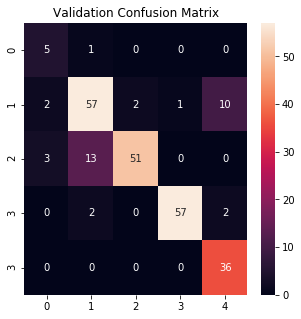

In [82]:
import numpy as np
from mxnet import gluon, autograd, ndarray
import mxnet as mx
import mxnet.ndarray as nd
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
from sklearn.metrics import accuracy_score

# Set this to GPU or CPU 
ctx = mx.gpu()
#ctx = mx.cpu()

# Set the batch size and initial learning rate
batch_size = 250
epochs = 40
learning_rate = 0.02
momentum = 0.1

# ------ Create Network and Training Logic -------- #

# Create the network. We have 5 classes
num_outputs = 5

net = build_network(num_outputs)

# freeze conv layers
#for param in net.collect_params().values(): # Or some other layers that you want. 
#    if "conv" in param.name:
#        param.grad_req = 'null'
for param in net.collect_params().values():
    print(param)

# Define loss and trainer.
softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})
#trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate, 'momentum': momentum})
# ------------------------------------------------- #

train_loader = gluon.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = gluon.data.DataLoader(validation_dataset, batch_size=batch_size)

train_losses = []
valid_losses = []
min_validation_loss = 1000
no_improvement_count = 0

for epoch in range(epochs):

    # decay learning rate after epoc 3
    #if epoch > 3:
    #        trainer.set_learning_rate(trainer.learning_rate * 0.8)
            
    # training loop (with autograd and trainer steps, etc.)
    cumulative_train_loss = 0
    train_predictions = []
    for i, (data, label) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            train_predictions = train_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
            loss = softmax_cross_etropy_loss(output, label)
            cumulative_train_loss = cumulative_train_loss + nd.sum(loss)
        loss.backward()
        trainer.step(data.shape[0])
        
    train_loss = cumulative_train_loss/len(train_images)

    # validation loop
    cumulative_valid_loss = 0
    val_predictions = []
    for i, (data, label) in enumerate(validation_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        val_predictions = val_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
        val_loss = softmax_cross_etropy_loss(output, label)
        cumulative_valid_loss = cumulative_valid_loss + nd.sum(val_loss)
        
    valid_loss = cumulative_valid_loss/len(validation_images)

    # graph training loss
    train_losses.append(train_loss.asnumpy()[0])
    valid_losses.append(valid_loss.asnumpy()[0])
    pd.DataFrame({'train_loss':train_losses, 'validation_loss': valid_losses}).plot()

    # Calculate training and validation accuracies
    train_accuracy = accuracy_score(train_labels, train_predictions)
    validation_accuracy = accuracy_score(validation_labels, val_predictions)
    
    # Print the summary and plot the confusion matrix after each epoch
    print("Epoch {}, training loss: {:.2f}, validation loss: {:.2f}, training accuracy: {:.2f}, validation accuracy: {:.2f}".format(epoch, train_loss.asnumpy()[0], valid_loss.asnumpy()[0], train_accuracy, validation_accuracy))
    plot_confusion_matrix(validation_labels, val_predictions)
    
    # drop out once we've stopped improving
    if valid_loss >= min_validation_loss :
        no_improvement_count = no_improvement_count + 1
        if no_improvement_count > 3 :
            break
    else :
        min_validation_loss = valid_loss
        no_improvement_count = 0

# 6. Test on test dataset
#### We are done with the training and validation. Let's get the test predictions below. 

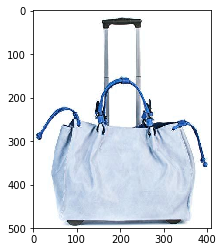

In [71]:
# If you're unsure of how to submit to Leaderboard, no problemo.You'll use the training file loaded above to make your ML model and then predict on the files below:

test_df = pd.read_pickle("/tmp/test_data.pkl")
plt.imshow(test_df['data'][101])

In [72]:
test_images = getImages(test_df["data"].values, 0)
test_loader = gluon.data.DataLoader(test_images, batch_size=batch_size)

test_predictions = []
for i, data in enumerate(test_loader):
    data = data.as_in_context(ctx)
    output = net(data)
    test_predictions = test_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
print(test_predictions)

[4, 4, 1, 1, 2, 4, 0, 3, 4, 1, 2, 4, 2, 0, 1, 1, 4, 1, 4, 1, 1, 4, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 4, 2, 1, 0, 2, 3, 3, 2, 1, 4, 2, 4, 3, 2, 2, 1, 0, 4, 1, 4, 1, 2, 1, 1, 4, 2, 2, 1, 1, 4, 4, 4, 2, 0, 1, 0, 1, 2, 4, 0, 4, 1, 4, 4, 4, 4, 1, 2, 4, 2, 1, 4, 4, 4, 1, 1, 2, 4, 1, 1, 1, 2, 2, 2, 3, 1, 1, 4, 1, 1, 4, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 1, 4, 1, 4, 4, 4, 1, 2, 4, 2, 0, 4, 1, 2, 4, 2, 1, 4, 2, 2, 1, 4, 2, 2, 2, 1, 3, 4, 2, 4, 4, 1, 4, 3, 4, 4, 1, 0, 0, 1, 3, 4, 1, 4, 2, 2, 0, 2, 2, 4, 4, 3, 2, 0, 1, 2, 4, 3, 2, 1, 2, 4, 4, 2, 4, 4, 2, 1, 1, 4, 4, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 1, 3, 4, 4, 2, 2, 2, 2, 2, 0, 2, 2, 4, 3, 1, 0, 2, 2, 1, 4, 2, 4, 1, 1, 2, 2, 1, 2, 1, 0, 1, 4, 1, 1, 0, 1, 0, 2, 1, 1, 2, 2, 4, 2, 2, 0, 4, 2, 1, 1, 4, 1, 1, 2, 4, 1, 1, 1, 4, 2, 4, 2, 2, 1, 1, 4, 2, 2, 4, 1, 0, 1, 4, 4, 2, 2, 2, 1, 4, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 3, 2, 1, 1, 2, 0, 0, 2, 4, 4, 1, 1, 1, 4, 0, 1, 4, 2, 1, 2, 2, 1, 1, 1, 1, 4, 1, 2, 2, 3, 0, 2, 0, 2, 2, 2, 4, 1, 

In [73]:
import pandas as pd

result_df = pd.DataFrame(columns=['ID', 'label'])
result_df["ID"] = test_df["ID"]
result_df["label"] = test_predictions

result_df.to_csv("results_cv_example_v3-10.csv", index=False)

If you navigate to the day1/results folder in the Jupyter file browser, you can select the results_cv_project.csv and dowload it locally. Or just click this [link...](./results_cv_project.csv)

## Getting our model output into Leaderboard

We now have our model's output .csv and are ready to upload to Leaderboard
1. Go to your class [Leaderboard instance](https://leaderboard.corp.amazon.com/tasks/312) and go to the 'Make a Submission' section
2. Upload your local file and include your notebook version URL for tracking
3. Your score on the public leaderboard should now appear. Marvel on how much room for improvement there is